Le prime celle mi servono per lavorare su Google colab

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls '/content/drive/My Drive/Coding/Projects/TEM'

Data			 trainHistoryDict_Sgd_v6  unet_tem_v3_Sgd.hdf5
trainHistoryDict_adam	 unet_tem.hdf5		  unet_tem_v4_Sgd.hdf5
trainHistoryDict_sgd	 unet_tem_v2_11apr.hdf5   unet_tem_v5_Sgd.hdf5
trainHistoryDict_Sgd	 unet_tem_v2_adam.hdf5	  unet_tem_v6_Sgd.hdf5
trainHistoryDict_Sgd_v3  unet_tem_v2_sgd.hdf5	  unet_tem_v7_Sgd.hdf5
trainHistoryDict_Sgd_v4  unet_tem_v2_Sgd.hdf5


In [1]:
##Imports
import os
import sys
import random
import pickle
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
#from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from keras.optimizers import adam
from keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf

#Seeding 
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

Using TensorFlow backend.


(1024, 1024, 3)
[0.33333333 0.66666667 1.        ]


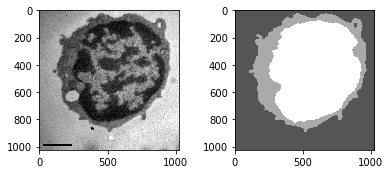

In [2]:
# se lavoro da locale 
#img_sample_local = cv2.imread('./Dataset/10_B1_19000x/data/10_B1_19000x.tif')
#mask_sample_local = cv2.imread('./Dataset/10_B1_19000x/masks/10_B1_19000x.tif_segmentation.tifnormalized.tif')

#se lavoro da Google Colab cambio path
img = cv2.imread('/content/drive/My Drive/Coding/Projects/TEM/Data/10_B1_19000x/data/10_B1_19000x.tif')
mask = cv2.imread('/content/drive/My Drive/Coding/Projects/TEM/Data/10_B1_19000x/masks/10_B1_19000x.tif_segmentation.tifnormalized.tif')
mask = mask/255
#mask_sample_local = mask_sample_local/255

%matplotib inline
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img)
#ax.imshow(img_sample_local)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)
#ax.imshow(mask_sample_local)


print(mask.shape)
print(np.unique(mask))
#print (mask_sample_local.shape)
#print (np.unique(mask_sample_local))

In [ ]:
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item
        
def sort_deduplicate(l):
    return uniq(sorted(l, reverse=True))

lista = []
for i in range(1024):
    for j in range(1024):
        lista.append(mask[i,j,:].tolist())     
       
    
palette_gen = sort_deduplicate(lista)
palette = []
for item in palette_gen:
    palette.append(item)
    
palette

In [0]:
class DataGen(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size=4 ):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.on_epoch_end()
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.x):
            self.batch_size = len(self.x) - index*self.batch_size

        batch_x = self.x[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = np.array(batch_x)
        masks  = np.array(batch_y)

        return images, masks
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.x)/float(self.batch_size)))

Setting hyperparameters: batch_size, epochs; 
Data preprocessing: resize 256x256, normalization, one_hot encoding; 
Data partitioning: 70% training set, 30% test set;

In [22]:
#data_path_local = './Dataset'
data_path = '/content/drive/My Drive/Coding/Projects/TEM/Data'
IMG_SIZE = 256
epochs = 400
batch_size = 4

X = []
Y = []
x_ids = next(os.walk(data_path))[1]
for id in x_ids :
    image_path = os.path.join(data_path, id, "data/", id) + '.tif'
    mask_path = os.path.join(data_path, id, "masks/", id) + '.tif_segmentation.tifnormalized.tif'

    img = cv2.imread(image_path)
    #Ridimensiono l'immagine da 1024x1024 a IMG_SIZE x IMG_SIZE (per esempio 256x256)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    #Normalizzazione (i nuovi valori saranno ora da 0 a 1)
    img = img/255.0

    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = mask/255

    #Codifica one-hot 
    one_hot_map = []
    for colour in palette:
        class_map = tf.reduce_all (tf.equal(mask,colour), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis = -1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    
    mask = np.asarray(one_hot_map)

    X.append(img)
    Y.append(mask)

X = np.asarray(X)
Y = np.asarray(Y)

#Partitionig dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=seed)

print ('Train samples = ', len(X_train), len(y_train))
print ('Test samples = ', len(X_test), len(y_test))

Train samples =  452 452
Test samples =  195 195


In [24]:
X_test[0].shape

(256, 256, 3)

In [10]:
#controllo che i batch siano esatti
gen = DataGen(X_train, y_train ,batch_size=batch_size)
x_train, y_train = gen.__getitem__(0)
print(x_train.shape, y_train.shape)

(4, 256, 256, 3) (4, 256, 256, 3)


In [11]:
#il 49 batch è composto da 3 e non da 4 immagini (48 batch*4img =192img + 1batch*3img)
gen_t = DataGen(X_test, y_test ,batch_size=batch_size)
x_te, y_te = gen_t.__getitem__(0)
print(x_te.shape, y_te.shape)

(4, 256, 256, 3) (4, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0. 255.]


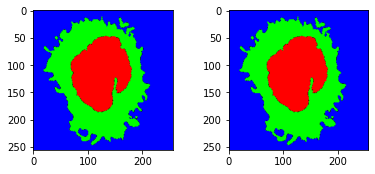

In [12]:
#I colori sono assegnati da matplotlib sia nel caso di numeri tra (0,1) che (0,255)

r = random.randint(0, len(x_train)-1)

%matplotib inline
#print(x.shape, y.shape)
mask = y_train[r]
mask[mask == 1] = 255
print (np.unique(mask))

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
#ax.imshow(x[r])
ax.imshow(mask)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y_train[r])

Definisco la Unet e le sue funzinoni

In [0]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [0]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(3, (1, 1), padding="same", activation="softmax")(u4)
    model = keras.models.Model(inputs, outputs)
    return model


In [32]:
#definisco un'altra metrica per la validazione dice score coefficient
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true*y_pred ), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

model = UNet()
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=["accuracy", dice_coef])
#model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=["accuracy", dice_coef])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [33]:
train_gen = DataGen(X_train, y_train, batch_size=batch_size)
test_gen = DataGen(X_test, y_test, batch_size=batch_size)

model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Coding/Projects/TEM/unet_tem_final_Adam.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
history = model.fit(train_gen, epochs=epochs, validation_data=test_gen, callbacks=[model_checkpoint]) 

with open('/content/drive/My Drive/Coding/Projects/TEM/trainHistoryDict_Adam_final', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
        
#model.load_weights('/content/drive/My Drive/Coding/Projects/TEM/unet_tem_final_Adam.hdf5')

Epoch 1/400
113/113 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.6913 - dice_coef: 0.8463
Epoch 00001: val_loss improved from inf to 0.74534, saving model to /content/drive/My Drive/Coding/Projects/TEM/unet_tem_final_Adam.hdf5
113/113 [==============================] - 4s 38ms/step - loss: 0.6583 - accuracy: 0.6913 - dice_coef: 0.8463 - val_loss: 0.7453 - val_accuracy: 0.6385 - val_dice_coef: 0.8193
Epoch 2/400
113/113 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.7880 - dice_coef: 0.8946
Epoch 00002: val_loss improved from 0.74534 to 0.41680, saving model to /content/drive/My Drive/Coding/Projects/TEM/unet_tem_final_Adam.hdf5
113/113 [==============================] - 4s 35ms/step - loss: 0.4428 - accuracy: 0.7880 - dice_coef: 0.8946 - val_loss: 0.4168 - val_accuracy: 0.8081 - val_dice_coef: 0.9006
Epoch 3/400
113/113 [==============================] - ETA: 0s - loss: 0.3898 - accuracy: 0.8185 - dice_coef: 0.9071
Epoch 00003: val_lo

Evaluation 

In [26]:
model.load_weights('/content/drive/My Drive/Coding/Projects/TEM/unet_tem_final_Sgd.hdf5')
#model.load_weights('./unet_tem_final_Sgd.hdf5')
results = model.evaluate(test_gen) #sgd

65/65 [==============================] - 1s 9ms/step - loss: 0.1509 - accuracy: 0.9405 - dice_coef: 0.9674


In [34]:
model.load_weights('/content/drive/My Drive/Coding/Projects/TEM/unet_tem_final_Adam.hdf5')
#model.load_weights('./unet_tem_final_Adam.hdf5')
results = model.evaluate(test_gen) #Adam

65/65 [==============================] - 1s 9ms/step - loss: 0.1438 - accuracy: 0.9524 - dice_coef: 0.9734


Confronto loss function e accuracy vs number of epocsh,
per training e test set,
utilizzando come optimizer Adam e SGD

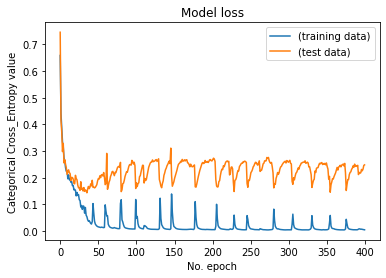

In [35]:
#ADAM Plot history: Categorical Cross_Entropy value
%matplotib inline
plt.plot(history.history['loss'], label='(training data)')
plt.plot(history.history['val_loss'], label='(test data)')
plt.title('Model loss')
plt.ylabel('Categorical Cross_Entropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

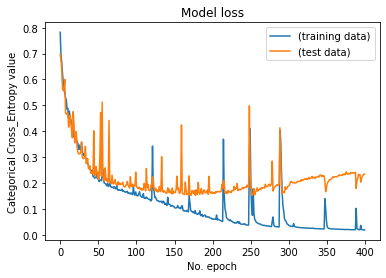

In [27]:
#SGD Plot history: Categorical Cross_Entropy value
%matplotib inline
plt.plot(history.history['loss'], label='(training data)')
plt.plot(history.history['val_loss'], label='(test data)')
plt.title('Model loss')
plt.ylabel('Categorical Cross_Entropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

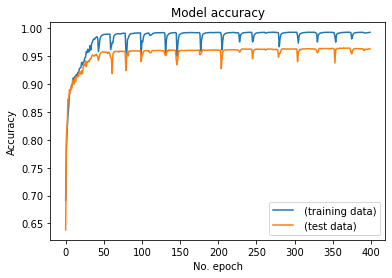

In [37]:
#ADAM Plot history: Accuracy
%matplotib inline
plt.plot(history.history['accuracy'], label=' (training data)')
plt.plot(history.history['val_accuracy'], label=' (test data)')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

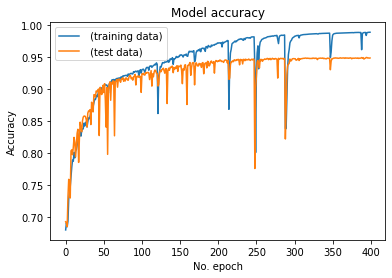

In [29]:
#SGD Plot history: Accuracy
%matplotib inline
plt.plot(history.history['accuracy'], label=' (training data)')
plt.plot(history.history['val_accuracy'], label=' (test data)')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [0]:
x, y = test_gen.__getitem__(1)  #Sgd
result = model.predict(x)

In [0]:
x, y = test_gen.__getitem__(1)  #Adam
result = model.predict(x)

Text(0.5, 0, 'Predicted mask')

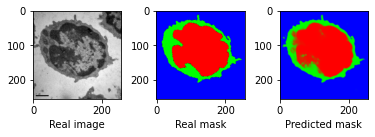

In [31]:
#SGD plot 
%matplotib inline
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[1])
ax.set_xlabel("Real image")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(y[1])
ax.set_xlabel("Real mask")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(result[1])
ax.set_xlabel("Predicted mask")

Text(0.5, 0, 'Predicted mask')

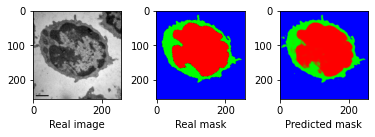

In [39]:
#Adam plot 
%matplotib inline
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[1])
ax.set_xlabel("Real image")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(y[1])
ax.set_xlabel("Real mask")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(result[1])
ax.set_xlabel("Predicted mask")